# About this Notebook

This notebook provides a first selection of data before using the models. The purpose is to see if it is possible to create a smaller data set before using them for the models and to have a first estimation of the elemnts contributing most to the creation of magnetic disturbance.

# Table of content

* [0 - Import Data](#)
    * [0.1 - Flight data](#)
    * [0.2 - Map data](#)
    * [0.3 - Generate Tolles-Lawson data + corrections](#)
        * [0.3.1 - Square compensation](#)
        * [0.3.2 - Cloverleaf compensation](#)
        * [0.3.3 - Square + Cloverleaf compensation](#)
* [1 - Data distribution](#)
* [2 - Correlation](#)
* [3 - Mutual information](#)
* [4 - XGBoost for feature selection](#)
* [5 - Feature engineering](#)
* [6 - Selected features](#)
* [7 - Training data](#)
    * [7.1 - Precautions](#)
    * [7.2 - Data slection](#)

# Setup

In [1]:
import os
# Move from notebooks to MagNav, run only one time
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/home/nlaoue/projet/MagNav/notebooks
/home/nlaoue/projet/MagNav


# Import packages

In [2]:
import pandas as pd
import ipywidgets as widgets
import src.magnav as magnav
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import datetime
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from ipyleaflet import Map, LocalTileLayer, Polyline, LegendControl, ScaleControl
from matplotlib.collections import LineCollection
from ipywidgets import Layout

# 0 - Import Data

## 0.1 - Flight data

In [3]:
flights = {}

# Flights to import
flights_num = [2,3,4,6,7]

for n in flights_num:
    df = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt100{n}')
    flights[n] = df

In [5]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5), ('1006', 6), ('1007', 7)],
    value=7,
    description='Load flight')
display(w_flight)

ToggleButtons(description='Load flight', index=5, options=(('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5),…

In [6]:
df_sel_flight = flights[w_flight.value]

## 0.2 - Map data

In [7]:
# Load anomaly maps
EasternMap = magnav.ChallMagMap('data/raw/Eastern_2.h5')
RenfrewMap = magnav.ChallMagMap('data/raw/Renfrew_2.h5')
GscMap     = magnav.ChallMagMap('data/external/Canada_MAG_RES_200m.hdf5')
WDMAM      = magnav.ChallMagMap('data/external/map_WDMAM.hdf5')

## 0.3 - Generate Tolles-Lawson data + corrections

In [8]:
mask_1 = (flights[2].LINE == 1002.02)
mask_2 = (flights[2].LINE == 1002.20)

tl_sq = flights[2][mask_1] # Square Tolles-Lawson pattern
tl_cl = flights[2][mask_2] # Cloverleaf Tolles-Lawson pattern

### 0.3.1 - Square compensation

In [9]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG1'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_2 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG2'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_3 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG3'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_4 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG4'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_5 = magnav.create_TL_coef(tl_sq['FLUXB_X'], tl_sq['FLUXB_Y'], tl_sq['FLUXB_Z'], tl_sq['UNCOMPMAG5'],
                                  lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_sq'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_sq'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_sq'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_sq'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_sq'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

### 0.3.2 - Cloverleaf compensation

In [10]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG1'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_2 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG2'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_3 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG3'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_4 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG4'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_5 = magnav.create_TL_coef(tl_cl['FLUXB_X'], tl_cl['FLUXB_Y'], tl_cl['FLUXB_Z'], tl_cl['UNCOMPMAG5'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_cl'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_cl'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_cl'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_cl'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_cl'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

### 0.3.3 - Square + Cloverleaf compensation

In [12]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Combine SQ and CL patterns
tl_sqcl = flights[2][mask_1+mask_2]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG1'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_2 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG2'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_3 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG3'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_4 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG4'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)
TL_coef_5 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'], tl_sqcl['FLUXB_Y'], tl_sqcl['FLUXB_Z'], tl_sqcl['UNCOMPMAG5'],
                           lowcut=lowcut, highcut=highcut, fs=fs, filter_params=filt, ridge=0.025)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'])

# Correct magnetometers measurements
df_sel_flight['TL_comp_mag1_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_sel_flight['TL_comp_mag2_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_sel_flight['TL_comp_mag3_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_sel_flight['TL_comp_mag4_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_sel_flight['TL_comp_mag5_sqcl'] = np.reshape(df_sel_flight['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

In [13]:
def apply_corrections(df,lag=True,diurnal=True,igrf=True):
    
    mag_measurements = np.array(['TL_comp_mag5_cl','TL_comp_mag4_cl','TL_comp_mag3_cl','TL_comp_mag2_cl','TL_comp_mag1_cl',
                        'TL_comp_mag5_sq','TL_comp_mag4_sq','TL_comp_mag3_sq','TL_comp_mag2_sq','TL_comp_mag1_sq',
                        'TL_comp_mag5_sqcl','TL_comp_mag4_sqcl','TL_comp_mag3_sqcl','TL_comp_mag2_sqcl','TL_comp_mag1_sqcl'])
    COR_df = df
    
    # Lag cor
    if lag == True:
        
        # 0.2s correction on mag1
        unlag = df[mag_measurements[[4,9,14]]].drop([df.index[0],df.index[1]])
        unlag.index = df.index[:-2]
        
        COR_df = df.drop([df.index[-1],df.index[-2]])
        COR_df = UNLAG_df.drop(columns=mag_measurements[[4,9,14]])
        COR_df[mag_measurements[[4,9,14]]] = unlag
    
    # Diurnal cor
    if diurnal == True:
        COR_df[mag_measurements] = COR_df[mag_measurements]-np.reshape(COR_df['DIURNAL'].values,[-1,1])
    
    # IGRF cor
    lat  = COR_df['LAT']
    lon  = COR_df['LONG']
    h    = COR_df['BARO']*1e-3 # Kilometers above WGS84 ellipsoid
    date = datetime.datetime(2020, 6, 29) # Date on which the flights were made
    Be, Bn, Bu = magnav.igrf(lon,lat,h,date)
    
    if igrf == True:
        COR_df[mag_measurements] = COR_df[mag_measurements]-np.reshape(np.sqrt(Be**2+Bn**2+Bu**2)[0],[-1,1])

    
    return COR_df

In [14]:
COR_df = apply_corrections(df_sel_flight,lag=False,diurnal=True,igrf=True)

# 1 - Data distribution

Now that we have most of our data ready to be used and we have a better understanding of the data, we can start selecting the features. First intuition :<br>
- Magnetometer 5 will be the most useful variable for the reconstruction of the truth
- Measurements of electrical elements near the selected magnetometers will be useful
- The attitude of the aircraft will also be useful

The feature selection was made on flights 1002 and 1003 as flights 1004 and 1005 are survey flights.

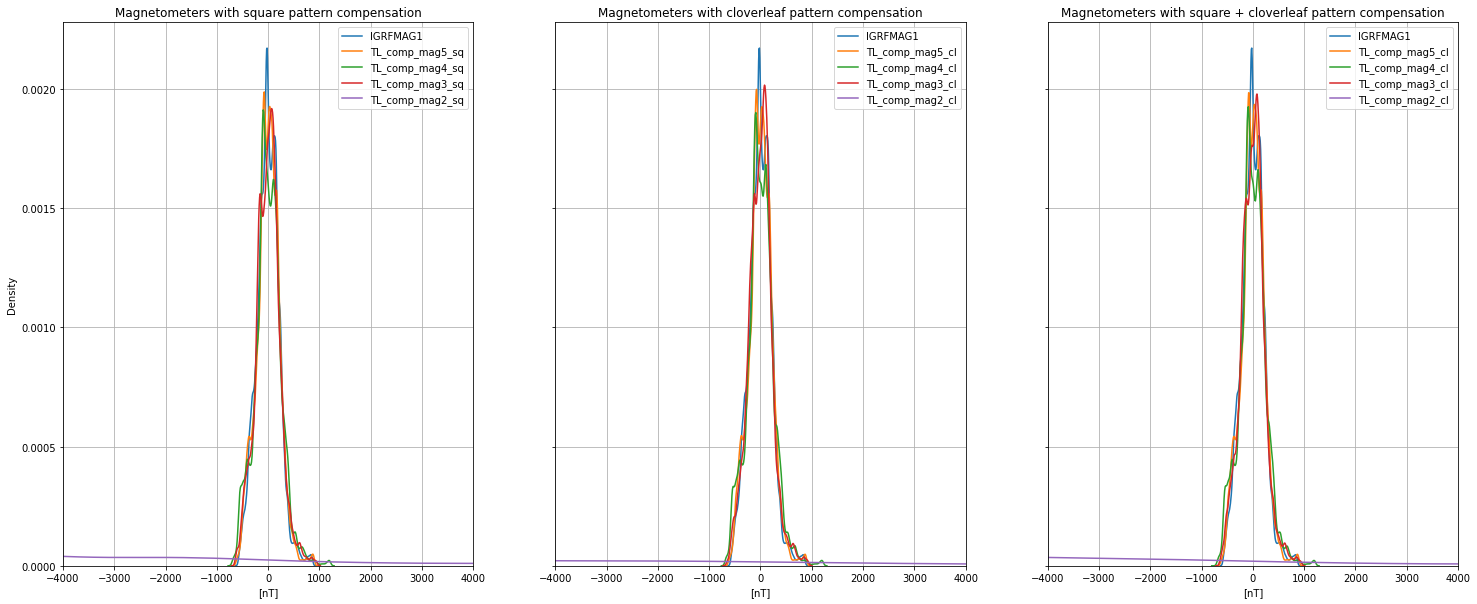

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[25,10],sharey=True)

sns.kdeplot(data=signal.detrend(COR_df['IGRFMAG1']),ax=ax1,label='IGRFMAG1')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag5_sq']),ax=ax1,label='TL_comp_mag5_sq')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag4_sq']),ax=ax1,label='TL_comp_mag4_sq')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag3_sq']),ax=ax1,label='TL_comp_mag3_sq')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag2_sq']),ax=ax1,label='TL_comp_mag2_sq')

ax1.set_xlabel('[nT]')
ax1.set_title('Magnetometers with square pattern compensation')
ax1.set_xlim(left=-4000,right=4000)
ax1.grid()
ax1.legend()

sns.kdeplot(data=signal.detrend(COR_df['IGRFMAG1']),ax=ax2,label='IGRFMAG1')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag5_cl']),ax=ax2,label='TL_comp_mag5_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag4_cl']),ax=ax2,label='TL_comp_mag4_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag3_cl']),ax=ax2,label='TL_comp_mag3_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag2_cl']),ax=ax2,label='TL_comp_mag2_cl')

ax2.set_xlabel('[nT]')
ax2.set_title('Magnetometers with cloverleaf pattern compensation')
ax2.set_xlim(left=-4000,right=4000)
ax2.grid()
ax2.legend()

sns.kdeplot(data=signal.detrend(COR_df['IGRFMAG1']),ax=ax3,label='IGRFMAG1')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag5_sqcl']),ax=ax3,label='TL_comp_mag5_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag4_sqcl']),ax=ax3,label='TL_comp_mag4_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag3_sqcl']),ax=ax3,label='TL_comp_mag3_cl')
sns.kdeplot(data=signal.detrend(COR_df['TL_comp_mag2_sqcl']),ax=ax3,label='TL_comp_mag2_cl')

ax3.set_xlabel('[nT]')
ax3.set_title('Magnetometers with square + cloverleaf pattern compensation')
ax3.set_xlim(left=-4000,right=4000)
ax3.grid()
ax3.legend()

plt.show()

<font size="4">Interpretation of results :</font><br>
Several elements emerge from the density plots :
- The magnetometer 5 has a distribution very close to the truth and seems to be a good choice as a variable for our model.
- Magnetometer 2 is completely off mark
- Magnetometers 3 and 4 have distributions closer to the truth in the case of a cloverleaf compensation

With this first approach we can already have information about the variables to select. A priori the magnetometer 5 is a very good candidate contrary to the magnetometer 2. As for the difference between the two compensations, it is not equal for all magnetometers. The cloverleaf compensation seems to be more interesting for magnetometers 3 and 4 and has no visible impact for magnetometer 5. It is reasonable to think that the cloverleaf compensation captures more of the aircraft's disturbing elements and this can be seen on magnetometers that are noisy. The mix of square + cloverleaf compensation seems not very relevant.

# 2 - Correlation

In this section we will use two different types of correlation to be able to show links between variables and the truth or between certain variables themselves.<br>
For this, 2 types of correlations are usable for our data :
- Pearson correlation coefficient
- Spearman's rank correlation coefficient
<br><br>

<font size='3'><b>Pearson correlation coefficient</b></font>
<br><br>
Pearson correlation coefficient is a measure of linear correlation between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations. The value is between -1 and 1 where 1 represent a perfect correlation, -1 a perfect opposite correlation and 0 no correlation.<br><br>
<font size='4'>
    $\rho_{X,Y}=\frac{cov(X,Y)}{\sigma_{X}\sigma_{Y}}$
</font>

- $cov$ is the covariance
- $\sigma_{X}$ is the standard deviation of X
- $\sigma_{Y}$ is the standrad deviation of Y
<br><br>

<font size='3'><b>Spearman's rank correlation coefficient</b></font>
<br><br>
Spearman's rank correlation coefficient is a nonparametric (distribution-free method) measure of [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation) (ordering the labels of a specific variables). It assesses how well the relationship between two variables can be described using a monotonic function (a function that is entirely non-increasing or non-decreasing). The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those 2 variables. While Pearson correlation assesses linear relationship, Spearman's correlation assesses monotonic relationships (wether linear or not). Same as Pearson correlation, the value is between -1 and 1 where 1 represent a perfect correlation, -1 a perfect opposite correlation and 0 no correlation.<br><br>
<font size='4'>
    $r_{s}=\rho_{R(X),R(Y)}=\frac{cov(R(X),R(Y))}{\sigma_{R(X)}\sigma_{R(Y)}}$
</font>

- $rho$ denotes the usual Pearson correlation coefficient, but applied to the rank variables
- $cov(R(X),R(Y))$ is the covariance of the rank variables
- $\sigma_{R(X)}$ and $\sigma_{R(Y)}$ iare the standrad deviation of the rank variables

Example available [here](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient#Example).<br>
The spearman method is interesting because it is robust to outliers.

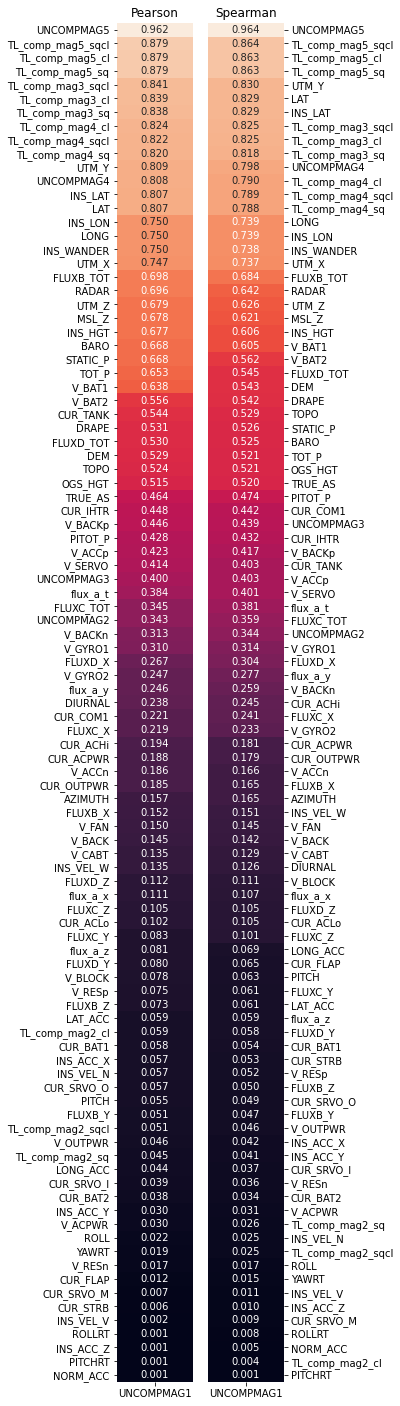

In [16]:
to_drop = ['LINE','FLT','IGRFMAG1','COMPMAG1','LAGMAG1','DCMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl','TIME','OGS_MAG']

corr_pearson   = COR_df.drop(columns=to_drop).corr(method='pearson')[['UNCOMPMAG1']].abs().sort_values(by='UNCOMPMAG1',ascending=False)
corr_spearman  = COR_df.drop(columns=to_drop).corr(method='spearman')[['UNCOMPMAG1']].abs().sort_values(by='UNCOMPMAG1',ascending=False)

corr_pearson   = corr_pearson.drop('UNCOMPMAG1')
corr_spearman  = corr_spearman.drop('UNCOMPMAG1')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=[3,25])

htmap_pearson  = sns.heatmap(corr_pearson,annot=True,fmt=".3f",ax=ax1,cbar=False)
htmap_spearman = sns.heatmap(corr_spearman,annot=True,fmt=".3f",ax=ax2,cbar=False)

htmap_spearman.set_title('Spearman')
htmap_pearson.set_title('Pearson')
htmap_spearman.yaxis.tick_right()
htmap_spearman.set_yticklabels(htmap_spearman.get_yticklabels(),rotation=0)
plt.show()

<font size="4">Interpretation of results :</font><br>
Before analyzing the results there are two points to consider :
- Pearson's and Spearman's correlations put forward linear or monotonic correlations. This means that there may be other more complex relationships between the variables that will not be highlighted here.
- The correlation above is between the truth ('IGRFMAG1', magnetometer 1 with the previous corrections) and the other variables of the dataset. But the truth is based on a magnetometer at the end of a pole that aims to get as far away as possible from the effects of the plane. This means that the truth captures very little or no effect of the aircraft. To compensate for this, we take the magnetometers that are most correlated with the truth and then correlate the selected magnetometers with the other variables in the dataset.

As we can see the magnetometer 5 is very correlated with the truth. In both cases the cloverleaf pattern seems to give slightly more information than the square pattern. The mix of the two patterns does not seem to be very efficient as concluded before. To go further, let's see with which variables Mag 5 is correlated (except orthers magnetometers).

In [17]:
to_drop_sq     = ['DIURNAL','TIME','LINE','FLT','UNCOMPMAG1','COMPMAG1','LAGMAG1','DCMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl','IGRFMAG1','TL_comp_mag5_cl','TL_comp_mag5_sqcl','TL_comp_mag3_sqcl','TL_comp_mag3_sq','TL_comp_mag3_cl',
           'TL_comp_mag4_sq','TL_comp_mag4_cl','TL_comp_mag4_sqcl','TL_comp_mag2_sq','TL_comp_mag2_cl','TL_comp_mag2_sqcl','UNCOMPMAG5','UNCOMPMAG4','UNCOMPMAG3','UNCOMPMAG2','OGS_MAG','FLUXB_TOT','FLUXD_TOT','FLUXC_TOT',
           'FLUXC_TOT','FLUXB_X','FLUXB_Y','FLUXB_Z','FLUXD_Z','FLUXC_Y','FLUXD_Y','FLUXD_X','FLUXC_X','INS_LAT','INS_LON','INS_WANDER','INS_HGT','UTM_X','UTM_Y','UTM_Z','MSL_Z','LAT','LONG','OGS_HGT','FLUXC_Z']
to_drop_cl     = ['DIURNAL','TIME','LINE','FLT','UNCOMPMAG1','COMPMAG1','LAGMAG1','DCMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl','IGRFMAG1','TL_comp_mag5_sq','TL_comp_mag5_sqcl','TL_comp_mag3_sqcl','TL_comp_mag3_sq','TL_comp_mag3_cl',
           'TL_comp_mag4_sq','TL_comp_mag4_cl','TL_comp_mag4_sqcl','TL_comp_mag2_sq','TL_comp_mag2_cl','TL_comp_mag2_sqcl','UNCOMPMAG5','UNCOMPMAG4','UNCOMPMAG3','UNCOMPMAG2','OGS_MAG','FLUXB_TOT','FLUXD_TOT','FLUXC_TOT',
           'FLUXC_TOT','FLUXB_X','FLUXB_Y','FLUXB_Z','FLUXD_Z','FLUXC_Y','FLUXD_Y','FLUXD_X','FLUXC_X','INS_LAT','INS_LON','INS_WANDER','INS_HGT','UTM_X','UTM_Y','UTM_Z','MSL_Z','LAT','LONG','OGS_HGT','FLUXC_Z']
to_drop_sqcl   = ['DIURNAL','TIME','LINE','FLT','UNCOMPMAG1','COMPMAG1','LAGMAG1','DCMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl','IGRFMAG1','TL_comp_mag5_cl','TL_comp_mag5_sq','TL_comp_mag3_sqcl','TL_comp_mag3_sq','TL_comp_mag3_cl',
           'TL_comp_mag4_sq','TL_comp_mag4_cl','TL_comp_mag4_sqcl','TL_comp_mag2_sq','TL_comp_mag2_cl','TL_comp_mag2_sqcl','UNCOMPMAG5','UNCOMPMAG4','UNCOMPMAG3','UNCOMPMAG2','OGS_MAG','FLUXB_TOT','FLUXD_TOT','FLUXC_TOT',
           'FLUXC_TOT','FLUXB_X','FLUXB_Y','FLUXB_Z','FLUXD_Z','FLUXC_Y','FLUXD_Y','FLUXD_X','FLUXC_X','INS_LAT','INS_LON','INS_WANDER','INS_HGT','UTM_X','UTM_Y','UTM_Z','MSL_Z','LAT','LONG','OGS_HGT','FLUXC_Z']
to_drop_uncomp = ['DIURNAL','TIME','LINE','FLT','UNCOMPMAG1','COMPMAG1','LAGMAG1','DCMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl','IGRFMAG1','TL_comp_mag5_cl','TL_comp_mag5_sqcl','TL_comp_mag3_sqcl','TL_comp_mag3_sq','TL_comp_mag3_cl',
           'TL_comp_mag4_sq','TL_comp_mag4_cl','TL_comp_mag4_sqcl','TL_comp_mag2_sq','TL_comp_mag2_cl','TL_comp_mag2_sqcl','TL_comp_mag5_sq','UNCOMPMAG4','UNCOMPMAG3','UNCOMPMAG2','OGS_MAG','FLUXB_TOT','FLUXD_TOT','FLUXC_TOT',
           'FLUXC_TOT','FLUXB_X','FLUXB_Y','FLUXB_Z','FLUXD_Z','FLUXC_Y','FLUXD_Y','FLUXD_X','FLUXC_X','INS_LAT','INS_LON','INS_WANDER','INS_HGT','UTM_X','UTM_Y','UTM_Z','MSL_Z','LAT','LONG','OGS_HGT','FLUXC_Z']

corr_pearson_sq  = COR_df.drop(columns=to_drop_sq).corr(method='pearson')[['TL_comp_mag5_sq']].abs().sort_values(by='TL_comp_mag5_sq',ascending=False)
corr_spearman_sq = COR_df.drop(columns=to_drop_sq).corr(method='spearman')[['TL_comp_mag5_sq']].abs().sort_values(by='TL_comp_mag5_sq',ascending=False)
corr_pearson_sq  = corr_pearson_sq.drop('TL_comp_mag5_sq')
corr_spearman_sq = corr_spearman_sq.drop('TL_comp_mag5_sq')

corr_pearson_cl  = COR_df.drop(columns=to_drop_cl).corr(method='pearson')[['TL_comp_mag5_cl']].abs().sort_values(by='TL_comp_mag5_cl',ascending=False)
corr_spearman_cl = COR_df.drop(columns=to_drop_cl).corr(method='spearman')[['TL_comp_mag5_cl']].abs().sort_values(by='TL_comp_mag5_cl',ascending=False)
corr_pearson_cl  = corr_pearson_cl.drop('TL_comp_mag5_cl')
corr_spearman_cl = corr_spearman_cl.drop('TL_comp_mag5_cl')

corr_pearson_sqcl  = COR_df.drop(columns=to_drop_sqcl).corr(method='pearson')[['TL_comp_mag5_sqcl']].abs().sort_values(by='TL_comp_mag5_sqcl',ascending=False)
corr_spearman_sqcl = COR_df.drop(columns=to_drop_sqcl).corr(method='spearman')[['TL_comp_mag5_sqcl']].abs().sort_values(by='TL_comp_mag5_sqcl',ascending=False)
corr_pearson_sqcl  = corr_pearson_sqcl.drop('TL_comp_mag5_sqcl')
corr_spearman_sqcl = corr_spearman_sqcl.drop('TL_comp_mag5_sqcl')

corr_pearson_uncomp  = COR_df.drop(columns=to_drop_uncomp).corr(method='pearson')[['UNCOMPMAG5']].abs().sort_values(by='UNCOMPMAG5',ascending=False)
corr_spearman_uncomp = COR_df.drop(columns=to_drop_uncomp).corr(method='spearman')[['UNCOMPMAG5']].abs().sort_values(by='UNCOMPMAG5',ascending=False)
corr_pearson_uncomp  = corr_pearson_uncomp.drop('UNCOMPMAG5')
corr_spearman_uncomp = corr_spearman_uncomp.drop('UNCOMPMAG5')

In [18]:
def transparent_plot(ax):
    ax.patch.set_alpha(0)
    ax.spines['bottom'].set_visible(False), ax.spines['top'].set_visible(False), ax.spines['left'].set_visible(False), ax.spines['right'].set_visible(False)
    ax.set_xticks([]) ,ax.set_yticks([])
    return ax

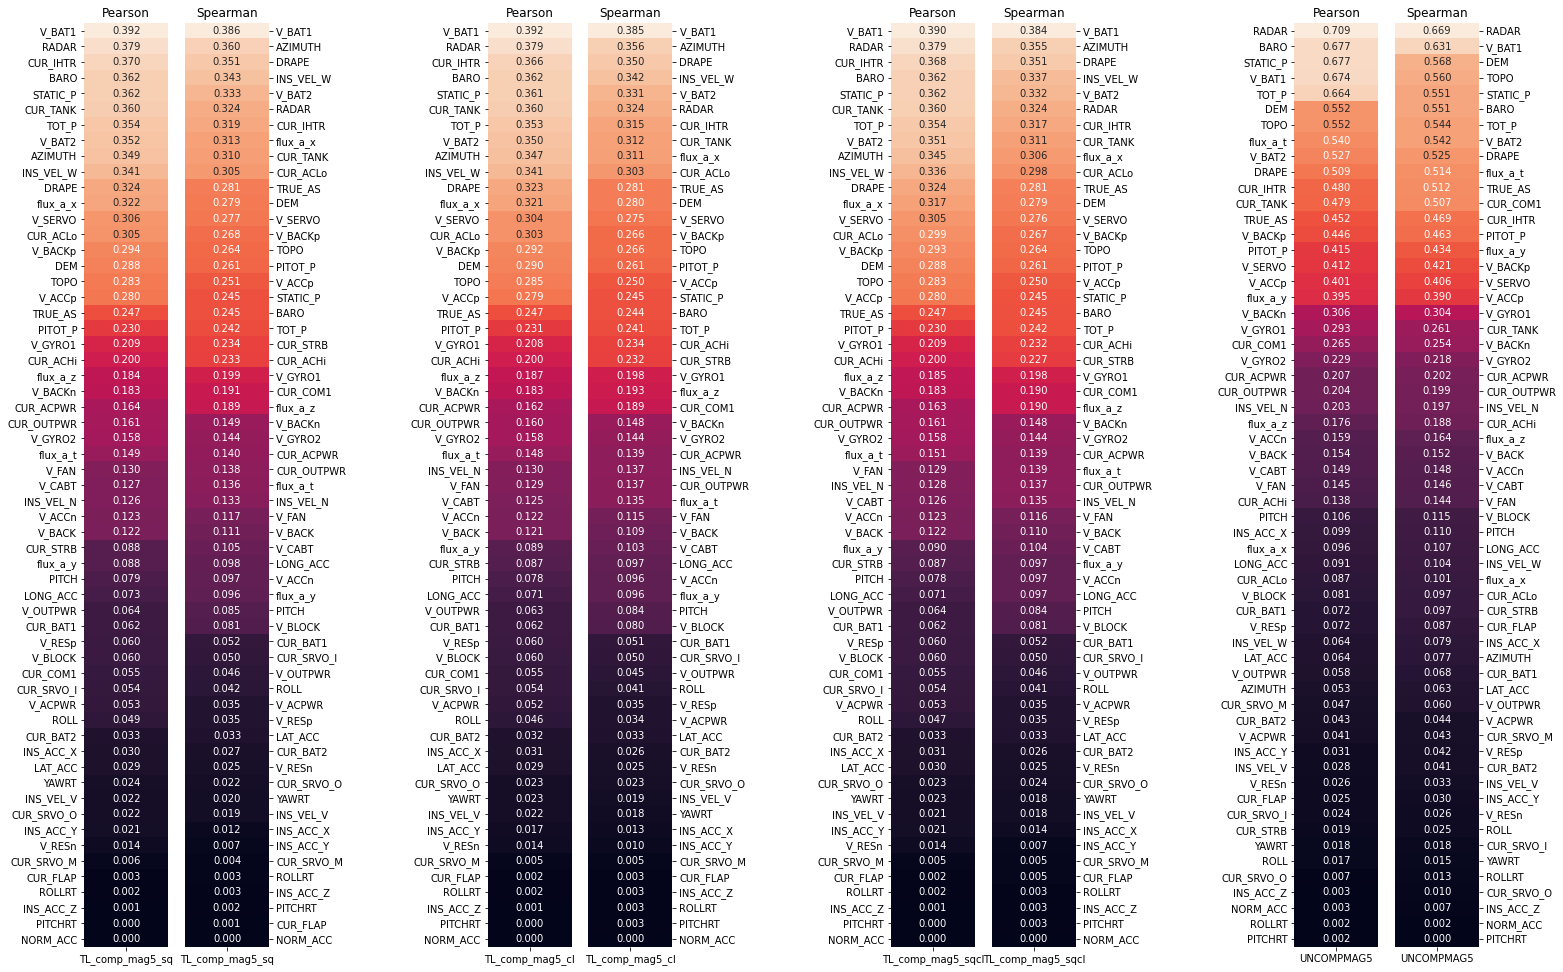

In [19]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14) = plt.subplots(1,14,figsize=[25,17])
transparent_plot(ax3),transparent_plot(ax4),transparent_plot(ax7),transparent_plot(ax8),transparent_plot(ax11),transparent_plot(ax12)

htmap_pearson_sq  = sns.heatmap(corr_pearson_sq,annot=True,fmt=".3f",ax=ax1,cbar=False)
htmap_spearman_sq = sns.heatmap(corr_spearman_sq,annot=True,fmt=".3f",ax=ax2,cbar=False)

htmap_spearman_sq.set_title('Spearman')
htmap_pearson_sq.set_title('Pearson')
htmap_spearman_sq.yaxis.tick_right()
htmap_spearman_sq.set_yticklabels(htmap_spearman_sq.get_yticklabels(),rotation=0)

htmap_pearson_cl  = sns.heatmap(corr_pearson_cl,annot=True,fmt=".3f",ax=ax5,cbar=False)
htmap_spearman_cl = sns.heatmap(corr_spearman_cl,annot=True,fmt=".3f",ax=ax6,cbar=False)

htmap_spearman_cl.set_title('Spearman')
htmap_pearson_cl.set_title('Pearson')
htmap_spearman_cl.yaxis.tick_right()
htmap_spearman_cl.set_yticklabels(htmap_spearman_cl.get_yticklabels(),rotation=0)

htmap_pearson_sqcl  = sns.heatmap(corr_pearson_sqcl,annot=True,fmt=".3f",ax=ax9,cbar=False)
htmap_spearman_sqcl = sns.heatmap(corr_spearman_sqcl,annot=True,fmt=".3f",ax=ax10,cbar=False)

htmap_spearman_sqcl.set_title('Spearman')
htmap_pearson_sqcl.set_title('Pearson')
htmap_spearman_sqcl.yaxis.tick_right()
htmap_spearman_sqcl.set_yticklabels(htmap_spearman_sqcl.get_yticklabels(),rotation=0)

htmap_pearson_uncomp  = sns.heatmap(corr_pearson_uncomp,annot=True,fmt=".3f",ax=ax13,cbar=False)
htmap_spearman_uncomp = sns.heatmap(corr_spearman_uncomp,annot=True,fmt=".3f",ax=ax14,cbar=False)

htmap_spearman_uncomp.set_title('Spearman')
htmap_pearson_uncomp.set_title('Pearson')
htmap_spearman_uncomp.yaxis.tick_right()
htmap_spearman_uncomp.set_yticklabels(htmap_spearman_uncomp.get_yticklabels(),rotation=0)

plt.show()

<font size="4">Interpretation of results :</font><br>
Same precautions as before on the analysis.

Several interesting facts stand out. First, the correlations between the variables and the Mag 5 are less strong with compensation than without, which seems logical because compensation reduces the effect of perturbations. The variable V_BAT1 is in the top 5 in each plot. This is very interesting because it means that battery 1 has an effect on the magnetometer measurements and therefore shows that the aircraft disturbs the measurements. The variables related to the INS also come up very often. The topography also seems to be an interesting element for the modeling. Let's continue our analysis to see if the same variables emerge with other methods.

# 3 - Mutual information

We will now use a new method that comes from probability theory and information theory, the mutual information. 
<br><br>
<font size='3'><b>Mutual Information</b></font>
<br><br>
The mutual information (MI) of two random variables is a measure of the mutual dependence between the two variables. More specifically, it quantifies the "amount of information" obtained about one random variable by observing the other random variable. The concept of mutual information is intimately linked to that of entropy (average level of "information", "surprise" or "uncertainty" inherent to the variable's possible outcomes) of a random variable.<br>
Not limited to real-valued random variables and linear dependance like the correlation coefficient, MI is more general and determines how different the joint distribution of the pair $(X,Y)$ is from the product of the marginal distributions of $X$ and $Y$.<br><br>
<font size='4'>
    $I(X;Y)=D_{KL}(P_{(X,Y)}\|P_{X}\otimes P_{Y})$
</font>

where :
- $D_{KL}$ is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback-Leibler_divergence), $D_{KL}(P\|Q)=\sum_{x\in{\mathcal{X}}}P(x)\log \left({\frac {P(x)}{Q(x)}}\right)$
- $P_{(X,Y)}$ is the joint distribution of $X$ and $Y$
- $P_X$ and $P_Y$ are the marginal distributions of $X$ and $Y$
- $\otimes$ is the [tensor product](https://en.wikipedia.org/wiki/Tensor_product)

When the MI is near 0, the quantities are independant. There is no upper bound but in practice values above 2 or so are uncommon (Mutual Information is a logarithmic quantity, so it increases very slowly).<br>
<br>
First, let's see if the data are indeed floats and if there is no NaN.

In [20]:
non_float = np.sum(COR_df.dtypes != float)
nans = df_sel_flight.isna().sum().sum()
print(f"Number of non float values : {non_float}\nNumber of Nans : {nans}\n")

Number of non float values : 0
Number of Nans : 14714



Some columns contain NaNs, let's see which ones.

In [21]:
# with pd.option_context('display.max_rows',None,'display.max_columns',None):
nans = COR_df.isna().sum()
print(nans[nans!=0].to_string())
nans_drop = nans[nans!=0].index.to_list()

DRAPE      4726
OGS_HGT    4726
OGS_MAG    5262


These three variables are redundant variables (other variables in the dataset express the same quantity). We can therefore ignore them for the calculation of the mutual information. In a different case, we have to find a strategy to fill in the NaNs or do the study on the part of the data without the NaNs.

In [23]:
def make_mi_scores(X,y,n_neighbors=3):
    
    mi_scores = mutual_info_regression(X,y,n_neighbors=n_neighbors)
    mi_scores = pd.Series(mi_scores, name = 'Mutual Informations scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

def plot_mi_scores(scores):
    
    scores = scores.sort_values(ascending=True)
    width  = np.arange(len(scores))
    ticks  = list(scores.index)
    bars   = plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.bar_label(bars,labels=[f'{x:.2f}' for x in bars.datavalues])
    plt.grid()
    plt.title("Mutual Information Scores")

In [24]:
# Relatively long execution time
mi_scores = make_mi_scores(COR_df.drop(columns=nans_drop+['IGRFMAG1','DCMAG1','LAGMAG1','COMPMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl','UNCOMPMAG1','TIME','FLT','LINE','OGS_MAG']),COR_df['UNCOMPMAG1'],n_neighbors=5)

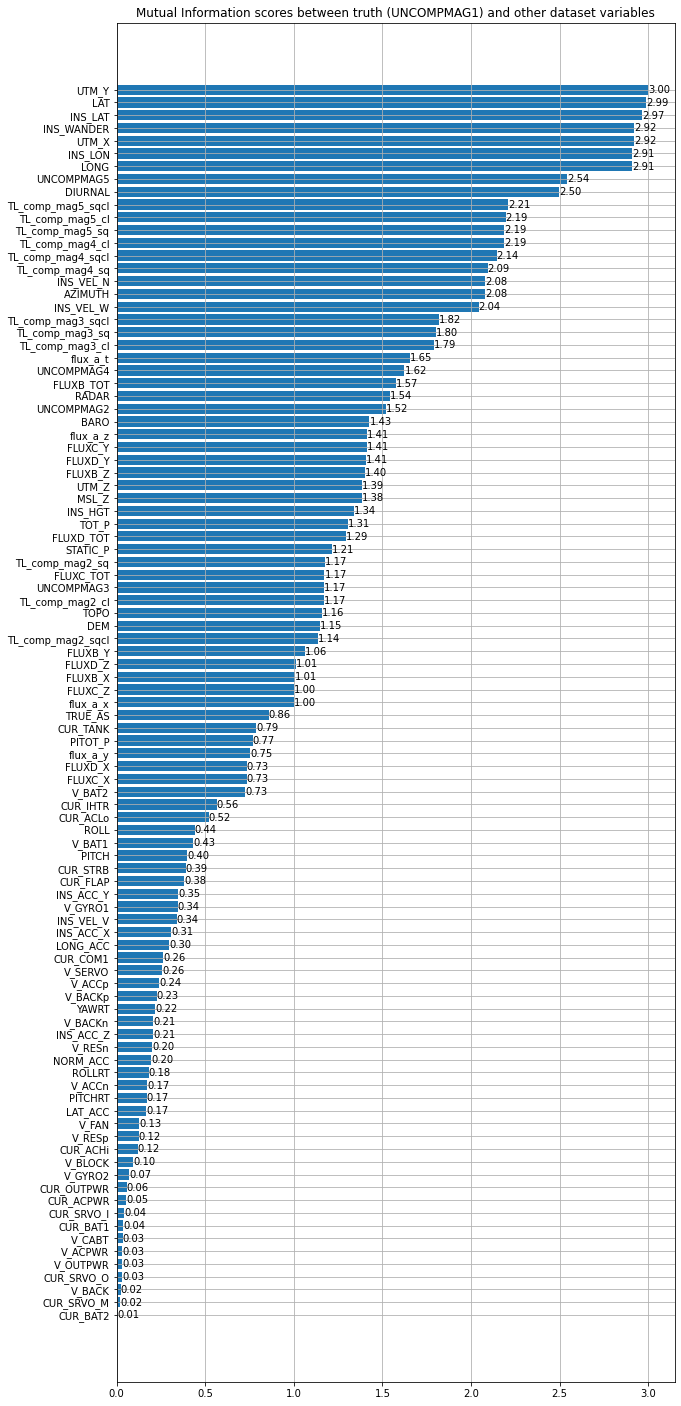

In [25]:
fig, ax = plt.subplots(figsize=[10,25])
plot_mi_scores(mi_scores)
plt.title('Mutual Information scores between truth (UNCOMPMAG1) and other dataset variables')
plt.show()

<font size="4">Interpretation of results :</font><br>
We adopt the same strategy as for the correlation, we look at the magnetometer most related to the truth then we choose it and look at the variables with which it has the most mutual information. We take again the magnetometer 5. We can also notice that the position (LAT,LONG) seems to share much information with the magnetic measurements. This is quite logical since each position in space is associated with a magnetic measurement.

In [26]:
# Relatively long execution time
mi_scores_uncompmag5    = make_mi_scores(COR_df.drop(columns=to_drop_uncomp+nans_drop+['UNCOMPMAG5']),COR_df['UNCOMPMAG5'],n_neighbors=5)
mi_scores_compmag5_sq   = make_mi_scores(COR_df.drop(columns=to_drop_sq+nans_drop+['TL_comp_mag5_sq']),COR_df['TL_comp_mag5_sq'],n_neighbors=5)
mi_scores_compmag5_cl   = make_mi_scores(COR_df.drop(columns=to_drop_cl+nans_drop+['TL_comp_mag5_cl']),COR_df['TL_comp_mag5_cl'],n_neighbors=5)
mi_scores_compmag5_sqcl = make_mi_scores(COR_df.drop(columns=to_drop_sqcl+nans_drop+['TL_comp_mag5_sqcl']),COR_df['TL_comp_mag5_sqcl'],n_neighbors=5)

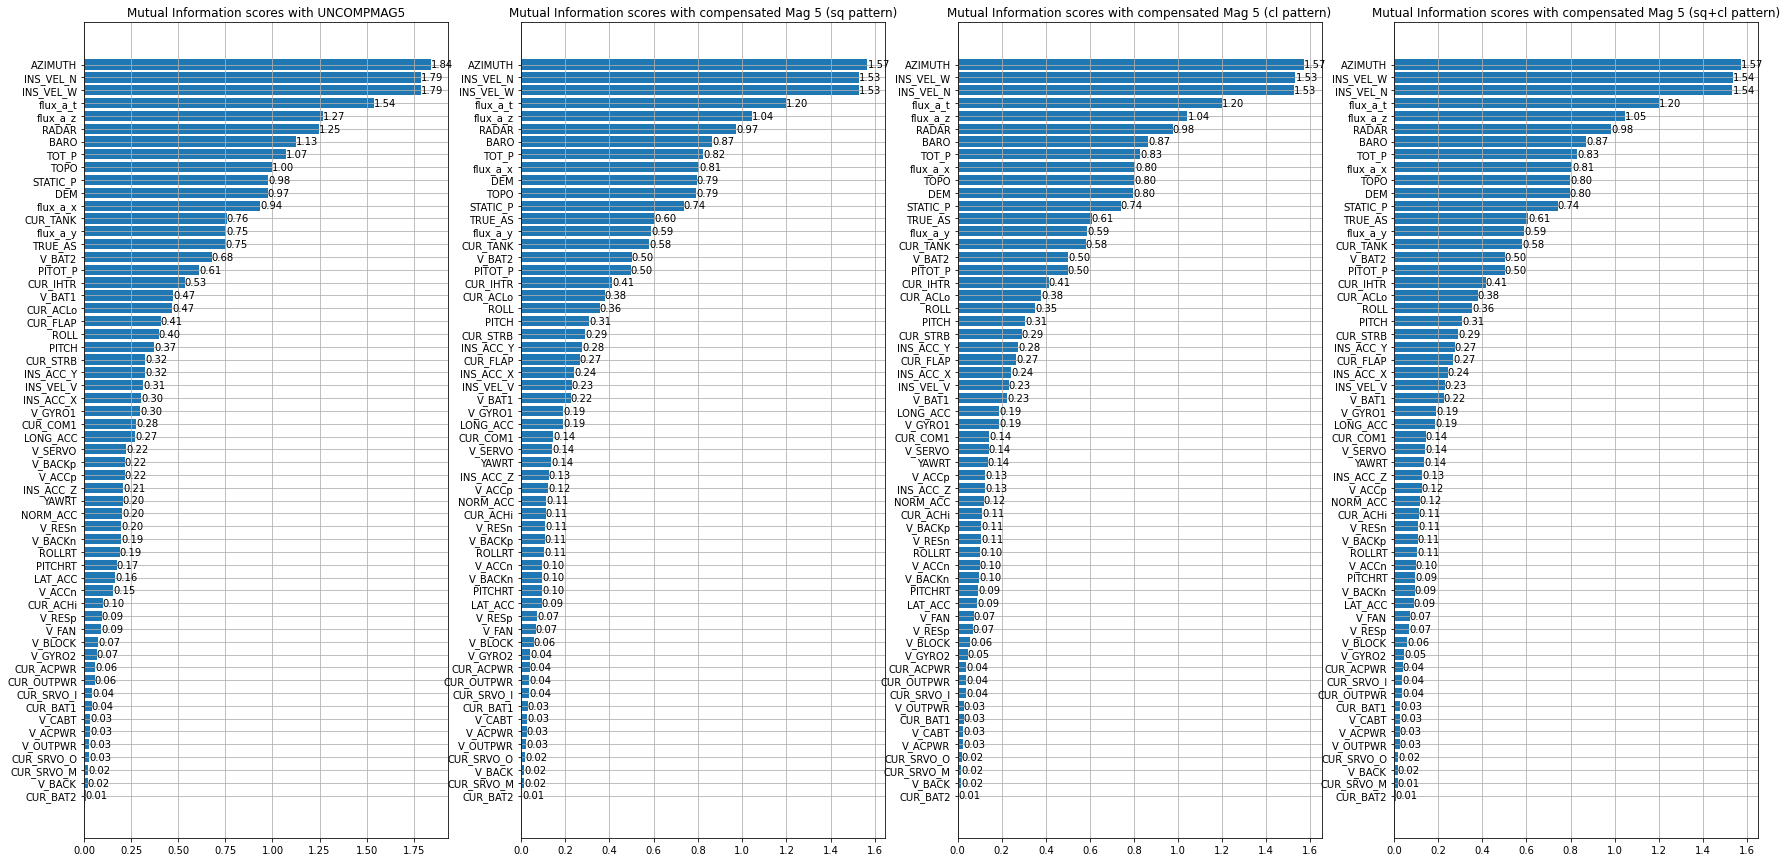

In [27]:
fig = plt.figure(figsize=[30,15])
plt.subplot(1,4,1)
plot_mi_scores(mi_scores_uncompmag5)
plt.title('Mutual Information scores with UNCOMPMAG5')
plt.subplot(1,4,2)
plot_mi_scores(mi_scores_compmag5_sq)
plt.title('Mutual Information scores with compensated Mag 5 (sq pattern)')
plt.subplot(1,4,3)
plot_mi_scores(mi_scores_compmag5_cl)
plt.title('Mutual Information scores with compensated Mag 5 (cl pattern)')
plt.subplot(1,4,4)
plot_mi_scores(mi_scores_compmag5_sqcl)
plt.title('Mutual Information scores with compensated Mag 5 (sq+cl pattern)')
plt.show()

<font size="4">Interpretation of results :</font><br>
We can notice that some variables are similar to what we could obtain with the correlation. We can notice that some variables are similar to what we could obtain with the correlation like the velocities calculated by the INS or the variables related to the topography. We can also notice that pressure measurements brings information. As the altitude brings information on the measurements (the altitude has an impact on the intensity of the measurement), the pressure measurements also bring information because they are intimately linked to the altitude (the pressure decreases when the altitude increases and conversely). Some electrical measurements are also interesting like V_BAT which was already present in the correlation. In view of the previous results, it seems reasonable to think that large electrical elements close to the magnetometer have a direct impact on the measurements and that therefore the use of voltage/current measurements for a machine learning model will be useful to denoise the magnetometers. In comparison, the electrical effects created by the movements of the control surfaces do not seem to have much effect. This may be due to the fact that the magnetometer 5 is located relatively far from the control surfaces.

# 4 - XGBoost for feature selection

Another interesting method for our data selection is the use of XGBoost. We will use XGBoost to fit our dataset and then we will use a feature of XGBoost that allows to see which variables are the most useful for the reconstruction of the truth.
<br><br>
<font size='3'><b>XGBoost</b></font>
<br><br>
XGBoost (eXtreme Gradient Boosting) is an open-source software library which provides a regularizing gradient boosting framework. XGBoost provides a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm, which attempts to accurtely predict a target variable by combining the estimates of a set of simpler, weaker models.<br>
When using gradient boosting for regression, the weak learners are regression trees, and each regression tree maps an input data point to one of its leafs that containes a continous score. XGBoost minimizes a regularized (L1 and L2) objective function that combines a convex loss function (based on the difference between the predicted and target outputs) and a penalty term for model complexity (in other words, the regression tree functions). The training proceeds iteratively, adding new trees that predict the residuals or errors of prior trees that are then combined with previous trees to make the final prediction. It's called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.<br>
<img src="../data/external/Images/xgboost.png" alt="xgboost" width="700"/>
<br>
<br>
where :
- $\alpha_i$ and $r_i$ are the regularization parameters and residuals computed with the $i^{ith}$ tree respectfully
- $h_i$ is a function that is trained to predict residuals, $r_i$ using $X$ for the $i^{ith}$ tree

In [28]:
X = COR_df.drop(['IGRFMAG1','COMPMAG1','DCMAG1','LAGMAG1','UNCOMPMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl','OGS_MAG'],axis=1)
y = COR_df['IGRFMAG1']

In [29]:
xgb_params = {
    'eta' : 0.05,
    'max_depth' : 10,
    'subsample' : 1.0,
    'colsample_bytree' : 0.7,
    'objective' : 'reg:squarederror',
    'eval_metric' : 'rmse',
}

In [30]:
dtrain = xgb.DMatrix(X,y,feature_names=X.columns.values)
model = xgb.train(dict(xgb_params),dtrain,num_boost_round=100)
remain_num = 99

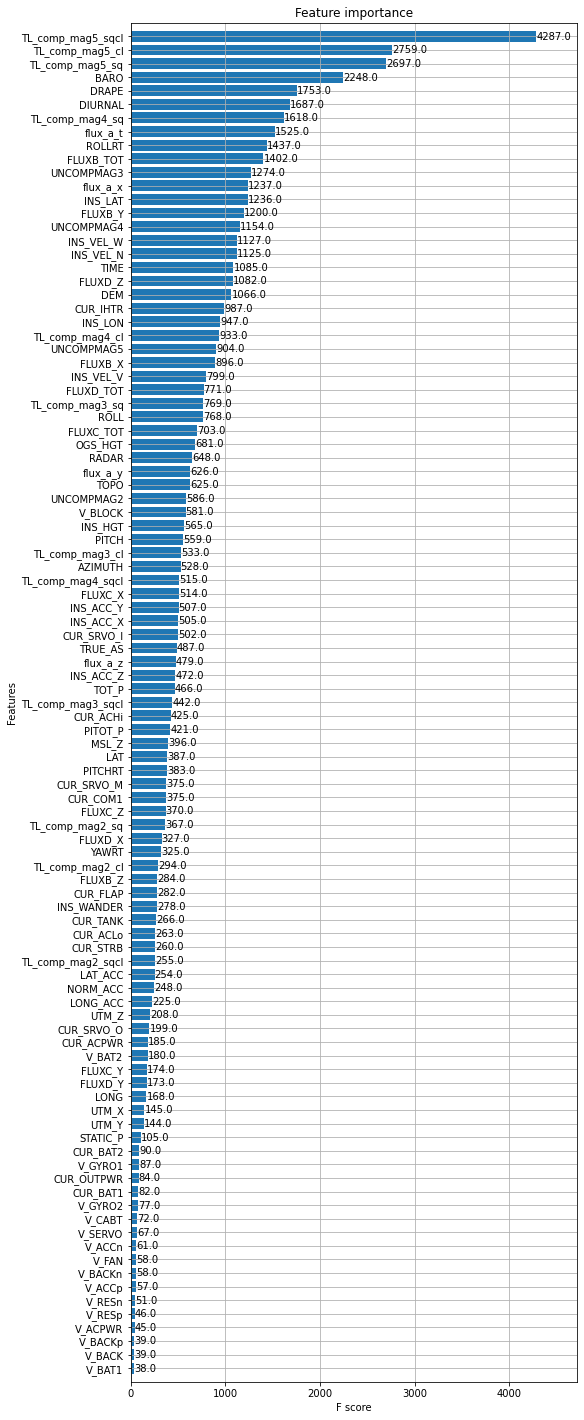

In [31]:
fig, ax = plt.subplots(figsize=[8,25])
xgb.plot_importance(model,max_num_features=remain_num,height=0.8, ax=ax)
plt.show()

<font size="4">Interpretation of results :</font><br>
First, if we look at the most important variables, we find the same as before with some exceptions. The measurement of the heater current of the INS seems to have a big impact also on the reconstruction of the truth. On the other hand, the impact of the batteries seems to be much less obvious than before.<br>
We can see that XGBoost also allows to classify the importance of the magnetometers. The magnetometer 5 is of course first but more surprinsigly, it uses mainly the magnetometer 4 instead of the magnetometer 3. In correlation or mutual information, the border between the usefulness of magnetometer 3 and 4 is very thin but it is not the case here.

# 5 - Feature selection

The last solution to get more information about our variables is the creation of new features. These new features correspond to the difference bewteen uncorrected and corrected magnetometers and the truth. Then we do a correlation with the dataset variables to see what's coming out. The goal is to see the variables related to the difference from the truth.<br>

<font size='3'>
    $New\_feature = truth - detrend(magnetometer)$
</font>

In [57]:
scaler = MinMaxScaler(feature_range=(-1,1))

df_res = pd.DataFrame()

# New feature
df_res['res_MAG5'] = COR_df['UNCOMPMAG5']-COR_df['UNCOMPMAG1']
# df_res['res_MAG5_tlsq'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_sq'])
df_res['res_MAG5_tlcl'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_cl'])
# df_res['res_MAG5_tlsqcl'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag5_sqcl'])

df_res['res_MAG4'] = COR_df['UNCOMPMAG4']-COR_df['UNCOMPMAG1']
# df_res['res_MAG4_tlsq'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_sq'])
df_res['res_MAG4_tlcl'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_cl'])
# df_res['res_MAG4_tlsqcl'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag4_sqcl'])

df_res['res_MAG3'] = COR_df['UNCOMPMAG3']-COR_df['UNCOMPMAG1']
# df_res['res_MAG3_tlsq'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_sq'])
df_res['res_MAG3_tlcl'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_cl'])
# df_res['res_MAG3_tlsqcl'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag3_sqcl'])

df_res['res_MAG2'] = COR_df['UNCOMPMAG2']-COR_df['UNCOMPMAG1']
# df_res['res_MAG2_tlsq'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag2_sq'])
df_res['res_MAG2_tlcl'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag2_cl'])
# df_res['res_MAG2_tlsqcl'] = COR_df['IGRFMAG1']-signal.detrend(COR_df['TL_comp_mag2_sqcl'])

In [62]:
variables = ['INS_VEL_W','INS_VEL_V','INS_VEL_N','TOPO','CUR_ACHi', 'CUR_ACLo', 'CUR_ACPWR', 'CUR_BAT1', 'CUR_BAT2', 'CUR_COM1',
       'CUR_FLAP', 'CUR_IHTR', 'CUR_OUTPWR', 'CUR_SRVO_I', 'CUR_SRVO_M',
       'CUR_SRVO_O', 'CUR_STRB', 'CUR_TANK', 'DIURNAL','INS_ACC_X', 'INS_ACC_Y',
       'INS_ACC_Z', 'AZIMUTH', 'PITCH', 'ROLL','V_ACCn', 'V_ACCp',
       'V_ACPWR', 'V_BACK', 'V_BACKn', 'V_BACKp', 'V_BAT1', 'V_BAT2',
       'V_BLOCK', 'V_CABT', 'V_FAN', 'V_GYRO1', 'V_GYRO2', 'V_OUTPWR',
       'V_RESn', 'V_RESp', 'V_SERVO']
residues_list = ['res_MAG5','res_MAG5_tlcl',#'res_MAG5_tlsqcl',
                 'res_MAG4','res_MAG4_tlcl',#'res_MAG4_tlsqcl',
                 'res_MAG3','res_MAG3_tlcl',#'res_MAG3_tlsqcl',
                 'res_MAG2','res_MAG2_tlcl']#,'res_MAG2_tlsqcl']

df_res[variables] = COR_df[variables]

res_pearson = df_res.corr(method='pearson')
res_pearson = res_pearson.drop(columns=variables)
res_pearson = res_pearson.drop(residues_list)

res_spearman = df_res.corr(method='spearman')
res_spearman = res_spearman.drop(columns=variables)
res_spearman = res_spearman.drop(residues_list)

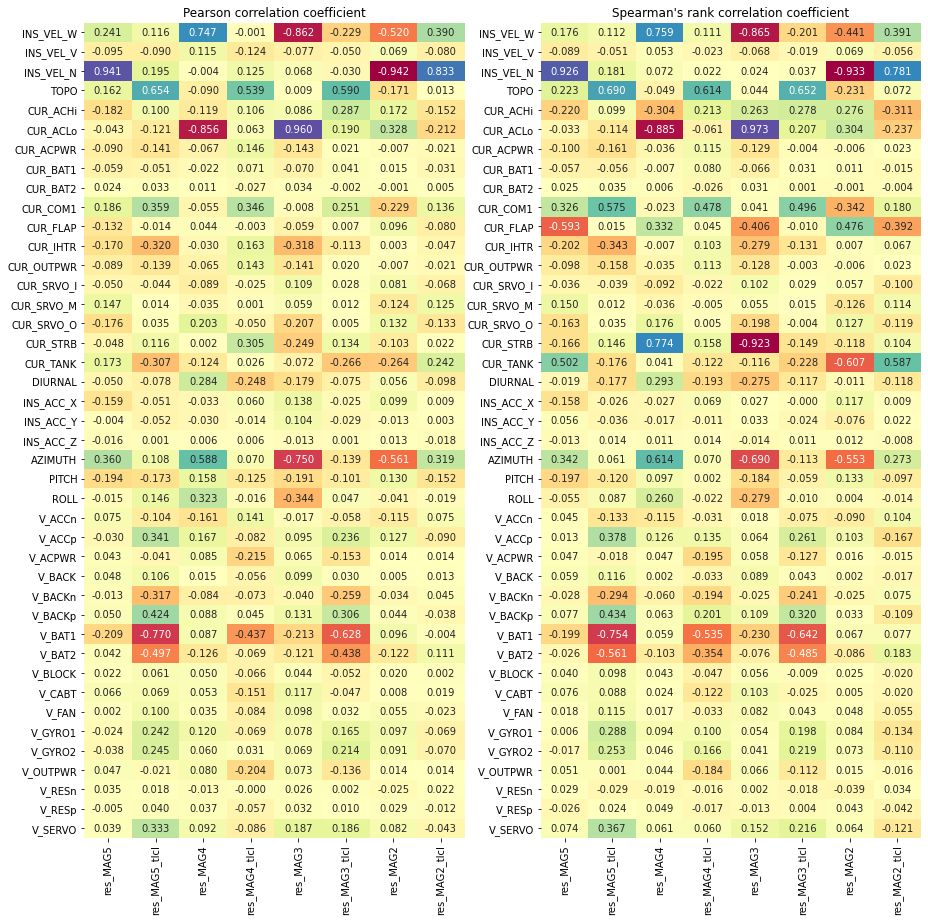

In [63]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[15,15])

pearson_htmap  = sns.heatmap(res_pearson,annot=True,fmt=".3f",ax=ax1,cmap="Spectral",cbar=False)
spearman_htmap = sns.heatmap(res_spearman,annot=True,fmt=".3f",ax=ax2,cmap="Spectral",cbar=False)

ax1.set_title('Pearson correlation coefficient')
ax2.set_title("Spearman's rank correlation coefficient")

plt.show()

<font size="4">Interpretation of results :</font><br>
Several interesting results emerge from the correlation matrices. We will analyze the results magnetometer by magnetometer. For the magnetometer 2, it is one of the noisiest magnetometers. It is unsuable in its current state and seems almost impossible to correct. In the case of a pearson correlation, no particular element stands out except the azimuth. The spearman correlation, in the other hand, highlights more elements. We can see that severals elements appear like the fuel pump of the cabin (CUR_TANK) or the flap motor (CUR_FLAP). The magnetometer 3 seems to be well correlated with the INS heater (CUR_IHTR) or the battery 1 (V_BAT1). Some other lighter correlations appear like the servo motors (V_SERVO) or the flap motors (CUR_FLAP). However in the case of these 2 magnetometers, we are missing elements on the effect of the motor. Since magnetometers 2 and 3 are the closest to the motor, there is surely a relationship but it is difficult to show with our data.<br>
Magnetometers 4 and 5 are much further from the cabin and therefore potentially from the effects of the engine. The magnetometer 4 also seems to be correlated with the INS heater (CUR_IHTR). The same goes for the servo motors (V_SERVO). From a general point of view, magnetometers 3 and 4 seem to have captured the same elements of the aircraft. <br>
The magnetometer 5 shows a strong correlation with the battery 1 (V_BAT1). There also seems to be a slight correlation with the INS accelerometers (V_ACCp). From a more general point of view, magnetometers 2 and 5 are those with the least number of correlated variables. The magnetometer 5 is the most isolated magnetometer from the effects of the aircraft and the magnetometer 2 is probably the one with the most undesirable effects of the aircraft (engine, cockpit, etc...). This explains why these are the measurements with the least correlation (magnetometer 2 is too noisy and magnetometer 5 is isolated from noise).

We can also use Tolles-Lawson coeffs to get more features. These features are great because they add scientific information about the data that we can explain.

In [44]:
def add_A_terms(flux_X,flux_Y,flux_Z,df,letter):
    
    A = magnav.create_TL_A(flux_X,flux_Y,flux_Z)
    
    # Permanent terms
    df[f'TL_flux{letter}_X'] = A[:,0]
    df[f'TL_flux{letter}_Y'] = A[:,1]
    df[f'TL_flux{letter}_Z'] = A[:,2]

    # Induced terms
    df[f'TL_flux{letter}_XX'] = A[:,3]
    df[f'TL_flux{letter}_XY'] = A[:,4]
    df[f'TL_flux{letter}_XZ'] = A[:,5]
    df[f'TL_flux{letter}_YY'] = A[:,6]
    df[f'TL_flux{letter}_YZ'] = A[:,7]
    df[f'TL_flux{letter}_ZZ'] = A[:,8]

    # Eddy terms
    df[f'TL_flux{letter}_XXdot'] = A[:,9]
    df[f'TL_flux{letter}_XYdot'] = A[:,10]
    df[f'TL_flux{letter}_XZdot'] = A[:,11]
    df[f'TL_flux{letter}_YXdot'] = A[:,12]
    df[f'TL_flux{letter}_YYdot'] = A[:,13]
    df[f'TL_flux{letter}_YZdot'] = A[:,14]
    df[f'TL_flux{letter}_ZXdot'] = A[:,15]
    df[f'TL_flux{letter}_ZYdot'] = A[:,16]
    df[f'TL_flux{letter}_ZZdot'] = A[:,17]
    
    return df

In [45]:
def add_BodytoNav_terms(Pitch,Yaw,Roll,df):
    # Matrix transition from body to Nav
    c_p = np.cos(Pitch) #p = pitch, y = yaw, r = roll, c = cos, s = sin
    s_p = np.sin(Pitch)
    c_y = np.cos(Yaw)
    s_y = np.sin(Yaw)
    c_r = np.cos(Roll)
    s_r = np.sin(Roll)

    df['TM1'] = c_p*c_y
    df['TM2'] = s_r*s_p*c_y-c_r*s_y
    df['TM3'] = c_r*s_p*c_y+s_r*s_y
    df['TM4'] = c_p*s_y
    df['TM5'] = s_r*s_p*s_y+c_r*c_y
    df['TM6'] = c_r*s_p*s_y-s_r*c_y
    df['TM7'] = -s_p
    df['TM8'] = s_r*c_p
    df['TM9'] = c_r*c_p
    
    return df

In [46]:
TL_cor_df = COR_df.copy()

add_A_terms(df_sel_flight['FLUXB_X'],df_sel_flight['FLUXB_Y'],df_sel_flight['FLUXB_Z'],TL_cor_df,'B')
add_A_terms(df_sel_flight['FLUXC_X'],df_sel_flight['FLUXC_Y'],df_sel_flight['FLUXC_Z'],TL_cor_df,'C')
add_A_terms(df_sel_flight['FLUXD_X'],df_sel_flight['FLUXD_Y'],df_sel_flight['FLUXD_Z'],TL_cor_df,'D')

add_BodytoNav_terms(df_sel_flight['PITCH'],df_sel_flight['AZIMUTH'],df_sel_flight['ROLL'],TL_cor_df)

,BARO,CUR_ACHi,CUR_ACLo,CUR_ACPWR,CUR_BAT1,CUR_BAT2,CUR_COM1,CUR_FLAP,CUR_IHTR,CUR_OUTPWR,...,TL_fluxD_ZZdot,TM1,TM2,TM3,TM4,TM5,TM6,TM7,TM8,TM9
Time [s],,,,,,,,,,,,,,,,,,,,,
47070.0,181.05,3.003,2.482,24.441,0.057,0.053,2.514,2.477,2.468,24.608,...,0.001997,0.240704,0.259822,0.935176,0.100718,0.951617,-0.290313,-0.965359,0.164069,0.202889
47070.1,181.38,3.012,2.483,25.381,0.059,0.052,2.517,2.477,2.508,25.505,...,0.001982,0.331531,-0.013818,0.943343,0.101210,0.994643,-0.021000,-0.938000,0.102438,0.331153
47070.2,181.73,3.037,2.487,25.942,0.056,0.050,2.520,2.477,2.531,26.051,...,0.001848,0.426361,-0.277477,0.860943,0.102664,0.960482,0.258716,-0.898708,-0.021918,0.437999
47070.3,182.08,3.032,2.488,27.172,0.054,0.045,2.518,2.477,2.544,27.344,...,0.001599,0.524290,-0.481581,0.702282,0.104257,0.854818,0.508348,-0.845133,-0.193303,0.498381
47070.4,182.43,3.010,2.488,27.456,0.052,0.042,2.520,2.477,2.529,27.741,...,0.001257,0.614429,-0.594903,0.518236,0.109456,0.714771,0.690740,-0.781343,-0.367686,0.504292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63799.6,237.03,3.001,2.489,24.848,0.057,0.053,2.528,2.471,2.127,25.022,...,-0.002038,0.595378,0.057535,0.801383,0.253906,-0.959790,-0.119728,0.762271,0.274760,-0.586046
63799.7,236.57,2.987,2.489,25.598,0.057,0.052,2.524,2.471,2.158,25.751,...,-0.002169,0.553739,0.433454,0.710978,0.349569,-0.895958,0.273970,0.755761,0.096828,-0.647650
63799.8,236.12,2.994,2.488,26.412,0.055,0.048,2.527,2.472,2.176,26.564,...,-0.002311,0.497912,0.715288,0.490353,0.413553,-0.692834,0.590723,0.762271,-0.091341,-0.640780


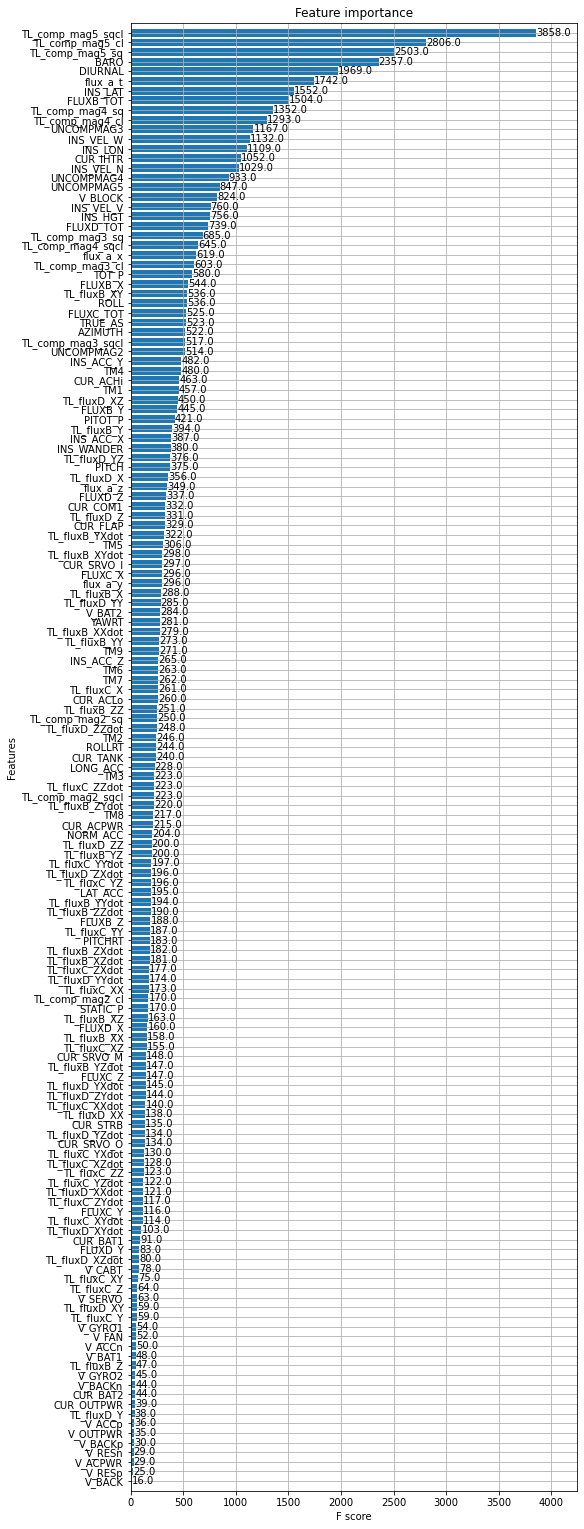

In [47]:
X = TL_cor_df.drop(['IGRFMAG1','COMPMAG1','DCMAG1','LAGMAG1','UNCOMPMAG1','TL_comp_mag1_sq','TL_comp_mag1_cl','TL_comp_mag1_sqcl',
                    'LINE','TIME','UTM_X','UTM_Y','UTM_Z','MSL_Z','LAT','LONG','RADAR','TOPO','DEM','DRAPE','OGS_MAG','OGS_HGT'],axis=1)
y = TL_cor_df['IGRFMAG1']

xgb_params = {
    'eta' : 0.05,
    'max_depth' : 10,
    'subsample' : 1.0,
    'colsample_bytree' : 0.7,
    'objective' : 'reg:squarederror',
    'eval_metric' : 'rmse',
}

dtrain = xgb.DMatrix(X,y,feature_names=X.columns.values)
model = xgb.train(dict(xgb_params),dtrain,num_boost_round=100)
remain_num = 200

fig, ax = plt.subplots(figsize=[8,27])
xgb.plot_importance(model,max_num_features=remain_num,height=0.8, ax=ax)
plt.show()

These new features seems not to have a big impact

# 6 - Selected features

After this data analysis, it is time to choose the features we will use for our model (they are not fixed and are subject to evolve).<br>
At first, the **magnetometers 5 and 4** seem to be good choices for our model with a **cloverleaf** pattern. The magnetometer 2 is too noisy and the magnetometer 3 is noisier than magnetometer 4. <br>
As for the different features of the magnetometers, here is the list of what has been chosen :
- V_BAT1/V_BAT2$~~~~~~~~~~~~~~$| A relationship has been clearly demonstrated before between the batteries and the measurements. We take both batteries as input and not only battery 1 because they work together.
- INS_VEL_N/W/V$~~~~~~~~~~~~~~$| Among all the analyses, the velocities calculated by the INS seem to correlate with our measurements. These features are therefore interesting for our model.
- BARO$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$| The altitude is also an important element for our model. In the case of magnetic measurements, it acts as a low pass filter and therefore having the current altitude measurement is a relevant feature.
- CUR_IHTR$~~~~~~~~~~~~~~~~~~~~~~$| This feature has been brought up by our previous analyses and also seems to have an impact on our measurements. Since it is an electrical element close to the magnetometers, and one of the elements with the highest current, it seems interesting to add this feature to our model.
- CUR_ACLo/CUR_ACHi
- CUR_TANK
- CUR_FLAP
- V_BLOCK
- PITCH/ROLL/AZIMUTH$~~~~$| Since to calibrate the effects of the aircraft we use the maneuvers of the control surfaces, it seems relevant to add the associated features. In the analyses, the link between the control surface movements and the magnetic measurements is not clear, but this mays be due to the fact that they are rather constant during the flight.

This is not definitive, we will also do test with the model directly to see feature importance.

# 7 - Training data

## 7.1 - Precautions

We now have our data for our training and we can start the model selection and the training of this model. However, our data are time series and, moreover, correspond to a spatial position. If we select all the lines of the flight 1003, we realize in [section 2](#2.1---OpenStreetMap) that some sections of the flight pass through the same places at different times. This leads to a potential leak of test data. Best example is flight 1003, section 1003.02 and 1003.04 correspond to the same trajectory at different times (but close enough in time to be considered identical). This can be also seen in the plots below where the error between the truth and the magnetometer seems to follow the longitude/latitude pattern.

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[25,10])

ax1.plot(df1003['IGRFMAG1']-df1003['UNCOMPMAG5'])
ax2.plot(df1003['LONG'])
ax3.plot(df1003['LAT'])
ax1.grid(),ax2.grid(),ax3.grid()
ax1.set_title('Error bewteen truth and UNCOMPMAG5'),ax2.set_title('Longitude'),ax3.set_title('Latitude')
ax1.set_xlabel('Time [s]'),ax2.set_xlabel('Time [s]'),ax3.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]'),ax2.set_ylabel('[deg]'),ax3.set_ylabel('[deg]')

plt.show()

## 7.2 - Data selection

We will therefore choose sections of different trajectories that represent a fairly wide variety of movement and that do not overlap or overlap a little.

In [ ]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3)],
    value=2,
    description='Load flight')
display(w_flight)

In [ ]:
df_sel_flight = eval(f'df100{w_flight.value}')

In [ ]:
# Does not work on jupyter lab

m = Map(center   = [45.1278, -75.5120],
        zoom     = 8,
        max_zoom = 12,
        min_zoom = 8,
        layout   = Layout(width='100%',height='800px'))

m.add_layer(LocalTileLayer(path="data/external/tiles/{z}/{x}/{y}.png"))

legend = LegendControl({},name="Legend",position="topright")
step = 10 
for line in df_sel_flight.LINE.unique():
    color = magnav.get_random_color()
    mask = (df_sel_flight.LINE == line)
    locations = (df_sel_flight
                 .loc[mask,['LAT','LONG']][::step]
                 .values
                 .tolist())
    pline = Polyline(
        locations = locations,
        color     = color,
        fill      = False,
        opacity   = 1)
    m.add_layer(pline)
    legend.add_legend_element(str(line),color)

m.add_control(legend)
m.add_control(ScaleControl(position='bottomleft'))

m

We can also see difference in magnitude to select lines with a significant magnitude

In [ ]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=[25,20])

# 1002
points = np.array([df1002['LONG'],df1002['LAT']]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)
lc = LineCollection(segments,cmap=plt.get_cmap('Spectral'))
lc.set_array(df1002['IGRFMAG1'])
lc.set_clim(vmin=-500,vmax=500)
ax1.add_collection(lc)
cbar = plt.colorbar(lc,ax=ax1,label='[nT]')

ax1.set_xlim(min(df1002['LONG'])-0.1,max(df1002['LONG'])+0.1)
ax1.set_ylim(min(df1002['LAT'])-0.1,max(df1002['LAT'])+0.1)
ax1.set_xlabel('Longitude'), ax1.set_ylabel('Latitude'), ax1.set_title('Flight 1002')
ax1.grid()

# 1003
points = np.array([df1003['LONG'],df1003['LAT']]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

lc = LineCollection(segments,cmap=plt.get_cmap('Spectral'))
lc.set_array(df1003['IGRFMAG1'])
lc.set_clim(vmin=-500,vmax=500)
ax2.add_collection(lc)

cbar = plt.colorbar(lc,ax=ax2,label='[nT]')

ax2.set_xlim(min(df1003['LONG'])-0.1,max(df1003['LONG'])+0.1)
ax2.set_ylim(min(df1003['LAT'])-0.1,max(df1003['LAT'])+0.1)
ax2.set_xlabel('Longitude'), ax2.set_ylabel('Latitude'), ax2.set_title('Flight 1003')
ax2.grid()

# 1004
points = np.array([df1004['LONG'],df1004['LAT']]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

lc = LineCollection(segments,cmap=plt.get_cmap('Spectral'))
lc.set_array(df1004['IGRFMAG1'])
lc.set_clim(vmin=-500,vmax=500)
ax3.add_collection(lc)

cbar = plt.colorbar(lc,ax=ax3,label='[nT]')

ax3.set_xlim(min(df1004['LONG'])-0.1,max(df1004['LONG'])+0.1)
ax3.set_ylim(min(df1004['LAT'])-0.1,max(df1004['LAT'])+0.1)
ax3.set_xlabel('Longitude'), ax3.set_ylabel('Latitude'), ax3.set_title('Flight 1004')
ax3.grid()

# 1005
points = np.array([df1005['LONG'],df1005['LAT']]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

lc = LineCollection(segments,cmap=plt.get_cmap('Spectral'))
lc.set_array(df1005['IGRFMAG1'])
lc.set_clim(vmin=-500,vmax=500)
ax4.add_collection(lc)

cbar = plt.colorbar(lc,ax=ax4,label='[nT]')

ax4.set_xlim(min(df1005['LONG'])-0.1,max(df1005['LONG'])+0.1)
ax4.set_ylim(min(df1005['LAT'])-0.1,max(df1005['LAT'])+0.1)
ax4.set_xlabel('Longitude'), ax4.set_ylabel('Latitude'), ax4.set_title('Flight 1005')
ax4.grid()

# 1006
points = np.array([df1006['LONG'],df1006['LAT']]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

lc = LineCollection(segments,cmap=plt.get_cmap('Spectral'))
lc.set_array(df1006['IGRFMAG1'])
lc.set_clim(vmin=-500,vmax=500)
ax5.add_collection(lc)

cbar = plt.colorbar(lc,ax=ax5,label='[nT]')

ax5.set_xlim(min(df1006['LONG'])-0.1,max(df1006['LONG'])+0.1)
ax5.set_ylim(min(df1006['LAT'])-0.1,max(df1006['LAT'])+0.1)
ax5.set_xlabel('Longitude'), ax5.set_ylabel('Latitude'), ax5.set_title('Flight 1006')
ax5.grid()

# 1007
points = np.array([df1007['LONG'],df1007['LAT']]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

lc = LineCollection(segments,cmap=plt.get_cmap('Spectral'))
lc.set_array(df1007['IGRFMAG1'])
lc.set_clim(vmin=-500,vmax=500)
ax6.add_collection(lc)

cbar = plt.colorbar(lc,ax=ax6,label='[nT]')

ax6.set_xlim(min(df1007['LONG'])-0.1,max(df1007['LONG'])+0.1)
ax6.set_ylim(min(df1007['LAT'])-0.1,max(df1007['LAT'])+0.1)
ax6.set_xlabel('Longitude'), ax6.set_ylabel('Latitude'), ax6.set_title('Flight 1007')
ax6.grid()

plt.show()

Selected sections :
Cross validation, flight 1003,1002 and 1007 used for testing and all other flights except 1005 also used for training